In [1]:
import os

# Set the KAGGLE_CONFIG_DIR environment variable to point to the /content directory.
# This tells the Kaggle API where to find the kaggle.json configuration file, which contains your Kaggle credentials.
# The /content directory is commonly used in Google Colab for storing files.
os.environ['KAGGLE_CONFIG_DIR'] = '/content'


In [2]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset #download dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [00:17<00:00, 151MB/s]
100% 2.04G/2.04G [00:17<00:00, 122MB/s]


In [ ]:
!unzip /content/plantvillage-dataset.zip -d /content/   #unzip file


Streaming output truncated to the last 5000 lines.
  inflating: /content/plantvillage dataset/segmented/Soybean___healthy/a853bc5c-405d-4dbf-b109-e1eef08ba983___RS_HL 6964_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Soybean___healthy/a85a16f9-cb7c-4949-94d3-9067f93e8866___RS_HL 2993_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Soybean___healthy/a860eed5-9939-4a96-a9f0-701f3d1dbbd4___RS_HL 5419_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Soybean___healthy/a864d9f5-f20b-444f-85ec-69ec145f4f1b___RS_HL 6390_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Soybean___healthy/a89de2f4-13d9-4685-9995-2c0e02c38b57___RS_HL 5085_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Soybean___healthy/a8ad6135-8fbe-45f5-bc74-d53b01ca258d___RS_HL 3809_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Soybean___healthy/a8b4ac4a-b246-4d37-8e8c-b0de14da1fe5__

In [1]:
# Install TensorFlow version 2.9.1.
!pip install tensorflow==2.9.1


In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

In [3]:
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

print ('modules loaded')

modules loaded


In [5]:
# Set the directory containing the dataset
data_dir = '/content/plantvillage dataset/color'

# Initialize empty lists to store file paths and corresponding labels
filepaths = []
labels = []

# List subdirectories within the main directory
folds = os.listdir(data_dir)

# Iterate over each subdirectory (class) in the dataset
for fold in folds:
    # Construct full path for the subdirectory
    foldpath = os.path.join(data_dir, fold)

    # List files within the subdirectory
    filelist = os.listdir(foldpath)

    # Iterate over each file in the subdirectory
    for file in filelist:
        # Construct full file path
        fpath = os.path.join(foldpath, file)

        # Append file path and corresponding label to lists
        filepaths.append(fpath)
        labels.append(fold)

# Create pandas Series for file paths and labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

# Concatenate Series objects along columns axis to create DataFrame
df = pd.concat([Fseries, Lseries], axis=1)

In [6]:
df


filepaths  \
0      /content/plantvillage dataset/color/Apple___Bl...   
1      /content/plantvillage dataset/color/Apple___Bl...   
2      /content/plantvillage dataset/color/Apple___Bl...   
3      /content/plantvillage dataset/color/Apple___Bl...   
4      /content/plantvillage dataset/color/Apple___Bl...   
...                                                  ...   
54300  /content/plantvillage dataset/color/Potato___E...   
54301  /content/plantvillage dataset/color/Potato___E...   
54302  /content/plantvillage dataset/color/Potato___E...   
54303  /content/plantvillage dataset/color/Potato___E...   
54304  /content/plantvillage dataset/color/Potato___E...   

                      labels  
0          Apple___Black_rot  
1          Apple___Black_rot  
2          Apple___Black_rot  
3          Apple___Black_rot  
4          Apple___Black_rot  
...                      ...  
54300  Potato___Early_blight  
54301  Potato___Early_blight  
54302  Potato___Early_blight  
54303  Potato___Early_blight  
54304  Potato___Early_blight  

[54305 rows x 2 columns]

In [7]:
# Extract labels from the DataFrame df
strat = df['labels']


In [8]:
# Split df into train_df and dummy_df
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)


In [9]:
# Further split dummy_df into valid_df and test_df
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)


In [10]:
# Define batch size and image size
batch_size = 128
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# ImageDataGenerator for data augmentation
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Generating data flow for training set
train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

# Generating data flow for validation set
valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

# Generating data flow for test set
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col='filepaths',
                                      y_col='labels',
                                      target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      shuffle=False,
                                      batch_size=batch_size)


Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


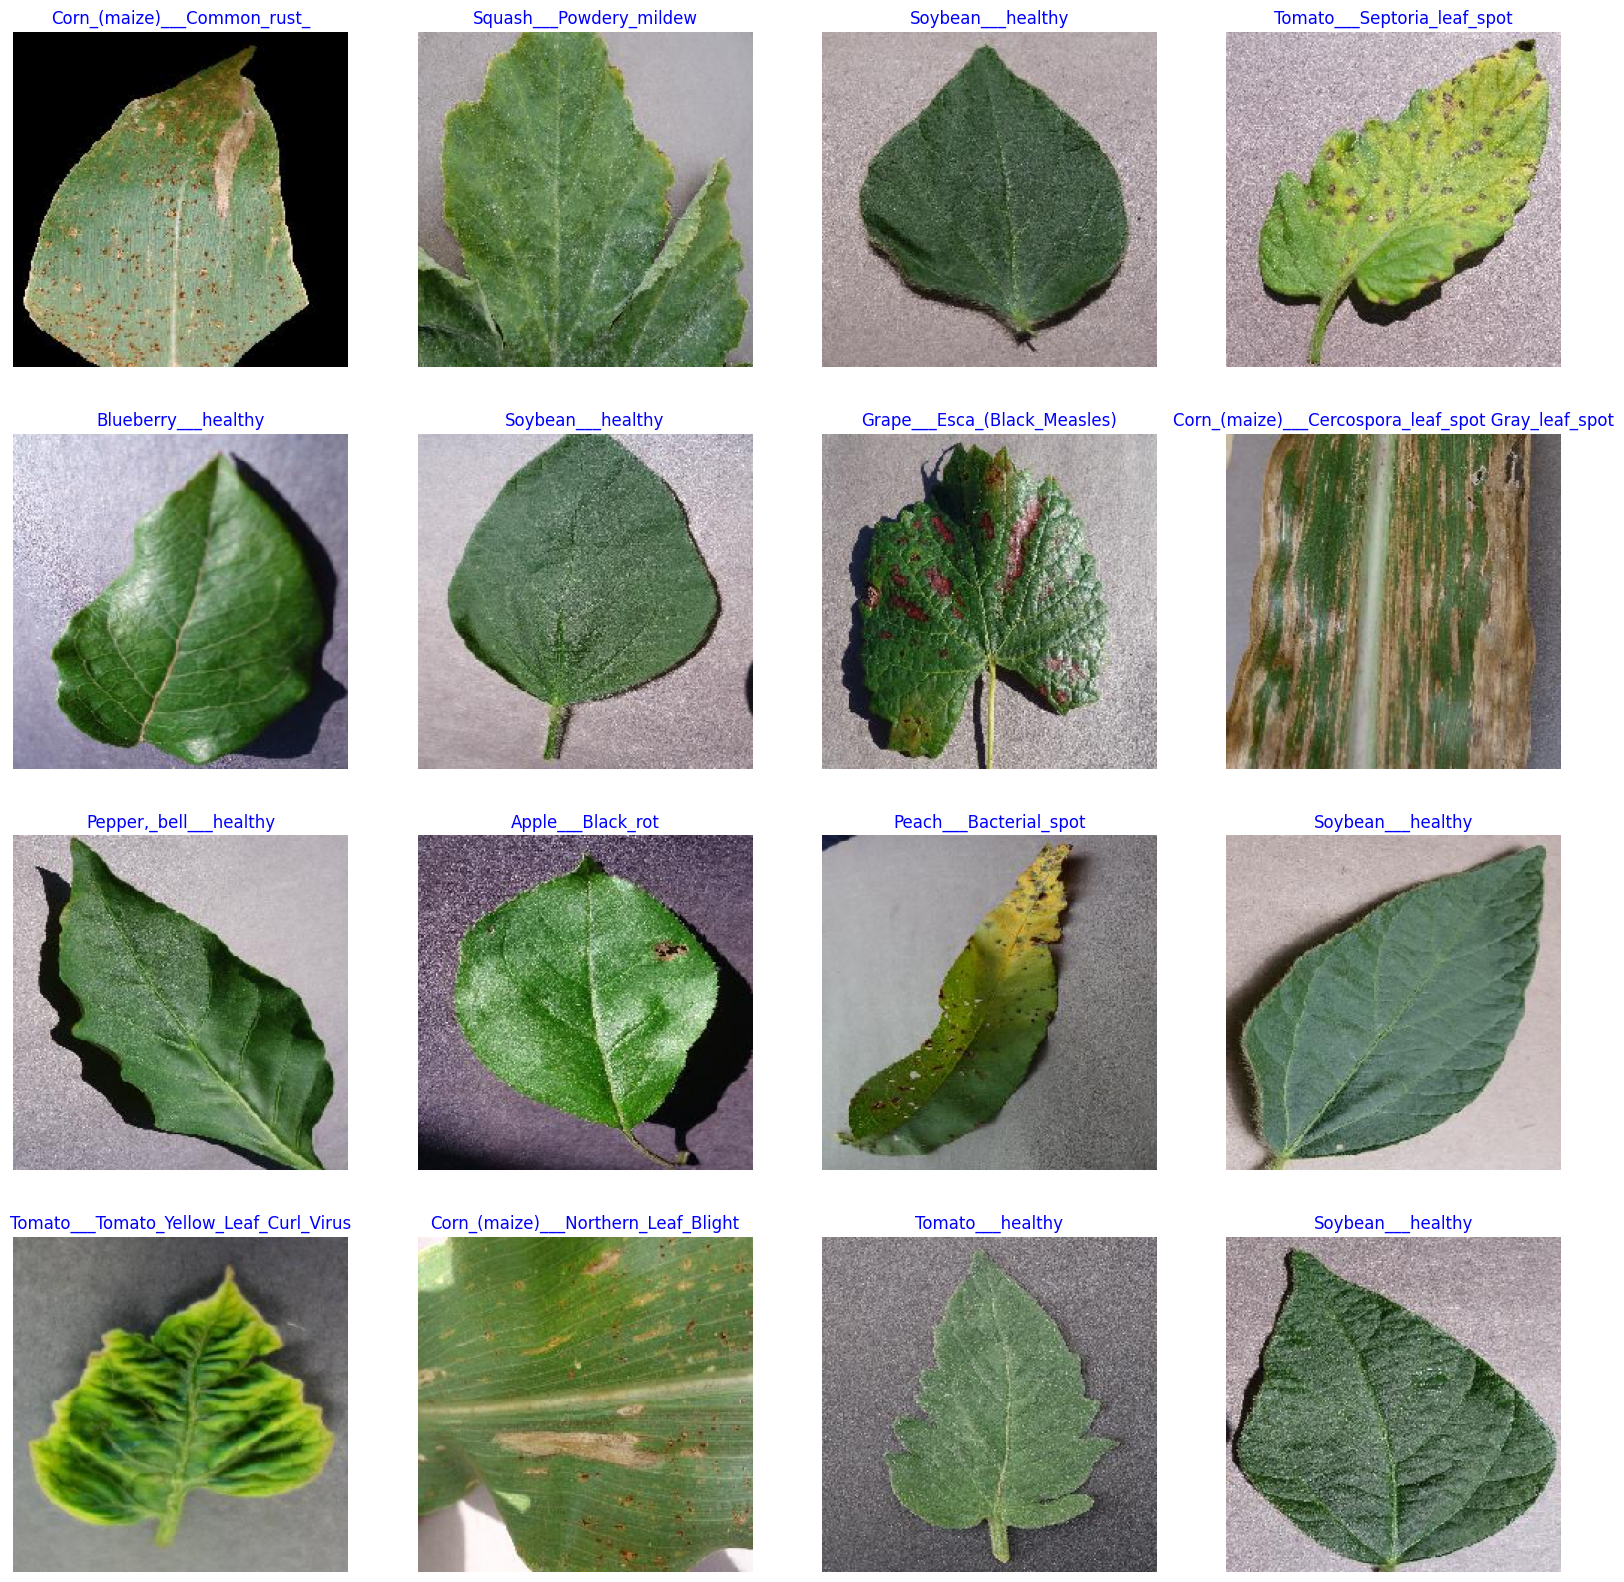

In [11]:
# Get the dictionary mapping class names to indices
g_dict = train_gen.class_indices

# Extract class names from the dictionary keys
classes = list(g_dict.keys())

# Get a batch of samples from the generator
images, labels = next(train_gen)

# Plotting the images
plt.figure(figsize=(20, 20))

# Loop through the batch of images
for i in range(16):
    # Create subplots
    plt.subplot(4, 4, i + 1)

    # Scale the image data to the range (0 - 1)
    image = images[i] / 255

    # Display the image
    plt.imshow(image)

    # Get the index of the label with the highest probability (one-hot encoding)
    index = np.argmax(labels[i])

    # Get the class name corresponding to the index
    class_name = classes[index]

    # Set the title of the subplot to the class name
    plt.title(class_name, color='blue', fontsize=12)

    # Turn off axis labels
    plt.axis('off')

# Show the plot
plt.show()
